## Image Captioning using KNN

Although VLMs (Vision Language Models) are the go to tools for image captioning right now, there are interesting works from earlier years that used KNN for captioning and perform surprisingly well enough!

Further, Libraries like [Faiss](https://engineering.fb.com/2017/03/29/data-infrastructure/faiss-a-library-for-efficient-similarity-search/) perform the nearest neighbor computation efficiently and are used in many industrial applications.

- In this question you will implement an algorithm to perform captioning using KNN based on the paper [A Distributed Representation Based Query Expansion Approach for
Image Captioning](https://aclanthology.org/P15-2018.pdf)

- Dataset: [MS COCO](https://cocodataset.org/#home) 2014 (val set only)

- Algorithm:
    1. Given: Image embeddings and correspond caption embeddings (5 Per image)
    1. For every image, findout the k nearest images and compute its query vector as the weighted sum of the captions of the nearest images (k*5 captions per image)
    1. The predicted caption would be the caption in the dataset that is closest to the query vector. (for the sake of the assignment use the same coco val set captions as the dataset)

- The image and text embeddings are extracted from the [CLIP](https://openai.com/research/clip) model. (You need not know about this right now)

- Tasks:
    1. Implement the algorithm and compute the bleu score. Use Faiss for nearest neighbor computation. Starter code is provided below.
    1. Try a few options for k. Record your observations.
    1. For a fixed k, try a few options in the Faiss index factory to speed the computation in step 2. Record your observations.
    1. Qualitative study: Visualize five images, their ground truth captions and the predicted caption.
    
Note: Run this notebook on Colab for fastest resu

In [ ]:
!pip uninstall --yes gdown
!pip install gdown -U --no-cache-dir
# !gdown 1b-4hU2Kp93r1nxMUGEgs1UbZov0OqFfW #caption embeddings
!gdown 1HZUWDcFP4EJuo76eZ49YZNTVuIn6BZ24 #caption embeddings
# !gdown 1RwhwntZGZ9AX8XtGIDAcQD3ByTcUiOoO #image embeddings
!gdown 1FPvSdUZMf0i57jQ7kfoNNNMh7L2tYitC #image embeddings
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip /content/val2014.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2014.zip
!unzip /content/annotations_trainval2014.zip
!pip install faiss-cpu

In [1]:
import nltk
nltk.download('punkt')
from PIL import Image
import faiss
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.translate import bleu_score
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import corpus_bleu
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import SmoothingFunction
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
def get_transform():
    transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),  # convert the PIL Image to a tensor
        transforms.Normalize(
            (0.485, 0.456, 0.406),  # normalize image for pre-trained model
            (0.229, 0.224, 0.225),
        )
    ])
    return transform


coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())
coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')
ids = list(sorted(coco_dset.coco.imgs.keys()))
captions = []
for i in range(len(ids)):
    captions.append([ele['caption'] for ele in coco_dset.coco.loadAnns(coco_dset.coco.getAnnIds(ids[i]))][:5]) #5 per image
captions_np = np.array(captions)
print('Captions:', captions_np[0])


loading annotations into memory...
Done (t=1.42s)
creating index...
index created!
loading annotations into memory...
Done (t=1.51s)
creating index...
index created!
Captions: ['This wire metal rack holds several pairs of shoes and sandals'
 'A dog sleeping on a show rack in the shoes.'
 'Various slides and other footwear rest in a metal basket outdoors.'
 'A small dog is curled up on top of the shoes'
 'a shoe rack with some shoes and a dog sleeping on them']


In [3]:


def extractCaptions(cocoDataset, maxCaptionsPerImage=5):
    imageIds = sorted(cocoDataset.coco.imgs.keys())
    allCaptions = []

    for imageId in imageIds:
        annotationIds = cocoDataset.coco.getAnnIds(imageId)
        annotations = cocoDataset.coco.loadAnns(annotationIds)

        captionsList = []
        for annotation in annotations:
            caption = annotation['caption']
            captionsList.append(caption)

        limitedCaptions = captionsList[:maxCaptionsPerImage]
        allCaptions.append(limitedCaptions)

    indexToFiveCaption = np.array(allCaptions)

    return indexToFiveCaption


In [4]:


def loadEmbeddings(captionPath, imagePath):
    captionEmbeddings = np.load(captionPath)
    imageEmbeddings = np.load(imagePath)

    return captionEmbeddings, imageEmbeddings



In [5]:



def accuracy_v2(predict, real):

    lower_n_split = lambda x: x.lower().split()

    accuracy = 0
    for i, pre in enumerate(predict):
        refs = real[i]
        score = bleu_score.sentence_bleu(list(map(lambda ref: lower_n_split(ref), refs)), lower_n_split(pre))
        accuracy += score
    return accuracy/len(predict)


In [6]:



import faiss
import numpy as np

def searchNearestNeighbors(indexToImageEmbedding, dimension, testImageIndex, k, faissTypeString):
    imageEmbeddings = np.array(indexToImageEmbedding, dtype=np.float32)
    testImageEmbedding = imageEmbeddings[testImageIndex].reshape(1, -1)

    if faissTypeString == "Flat":
        index = faiss.IndexFlatL2(dimension)

    elif faissTypeString == "IVF_Flat":
        quantizer = faiss.IndexFlatL2(dimension)  # the other index
        nlist = 100  # number of clusters
        index = faiss.IndexIVFFlat(quantizer, dimension, nlist, faiss.METRIC_L2)

    elif faissTypeString == "IVF_PQ":
        quantizer = faiss.IndexFlatL2(dimension)
        nlist = 100
        m = 8
        index = faiss.IndexIVFPQ(quantizer, dimension, nlist, m, 8)

    elif faissTypeString == "HNSW":
        index = faiss.IndexHNSWFlat(dimension, 32)

    elif faissTypeString == "PQ":
        m = 8
        index = faiss.IndexPQ(dimension, m, 8)

    elif faissTypeString == "OPQ":
        m = 8
        index = faiss.IndexPQ(dimension, m, 8)
        index = faiss.IndexPreTransform(index)

    elif faissTypeString == "PCA":
        mat = faiss.PCAMatrix (dimension, 10)
        index = faiss.IndexFlatL2(10)
        index = faiss.IndexPreTransform(mat, index)

    else:
        raise ValueError("Unsupported faissTypeString: {}".format(faissTypeString))

    if not index.is_trained:
        index.train(imageEmbeddings)

    index.add(imageEmbeddings[:testImageIndex - 1])
    distances, indices = index.search(testImageEmbedding, k)

    return distances, indices




In [7]:

def compute_query_vector(KNeighbourDistances, KNeighbourIndexes, indexNCaptionToCaptionEmbedding, k):
    similarities = 1 / (1 + KNeighbourDistances)

    kNearestCaptionEmbedding = []

    for index in KNeighbourIndexes:
        current_embedding = indexNCaptionToCaptionEmbedding[index, :, :]
        kNearestCaptionEmbedding.append(current_embedding)

    kNearestCaptionEmbedding = np.array(kNearestCaptionEmbedding)

    weighted_sum = np.sum(kNearestCaptionEmbedding * similarities[:, np.newaxis, np.newaxis], axis=(0, 1))
    captionscount =(k * 5)
    weightedVal= weighted_sum / captionscount

    return weightedVal


In [8]:
def rerank_captions(q1, indexNCaptionToCaptionEmbedding, I, coco_dset1, indexToFiveCaption,testImageIndex):
    max_similarity = float('inf')
    image_index, caption_index = -1, -1

    for index in I:
        captions = indexNCaptionToCaptionEmbedding[index]
        similarity_values = [1 - cosine(q1, caption) for caption in captions]
        i, similarity = min(enumerate(similarity_values), key=lambda x: x[1])
        if similarity < max_similarity:
            max_similarity, image_index, caption_index = similarity, index, i


    return indexToFiveCaption[image_index][caption_index]



In [27]:




max_captions_per_image = 5

indexToFiveCaption = extractCaptions(coco_dset, max_captions_per_image)
cap_path = '/content/coco_captions.npy'
img_path = '/content/coco_imgs.npy'

indexNCaptionToCaptionEmbedding, indexToImageEmbedding = loadEmbeddings(cap_path, img_path)


embeddingDimention = 512



results = {}
for kNearest in [1,2,3,4,5]:  # Example k values
    print("for K:",kNearest)
    predicted = []
    actual = []

    for testImageIndex in range(40400,40503):
        Distances, Indexes = searchNearestNeighbors(indexToImageEmbedding, embeddingDimention, testImageIndex, kNearest,"IVF_Flat")
        KNeighbourIndexes = Indexes[0];
        KNeighbourDistances = Distances[0];
        q1 = compute_query_vector(KNeighbourDistances, KNeighbourIndexes, indexNCaptionToCaptionEmbedding, kNearest)
        closest_captions = rerank_captions(q1, indexNCaptionToCaptionEmbedding, KNeighbourIndexes,coco_dset1,indexToFiveCaption,testImageIndex)
        actual.append(indexToFiveCaption[testImageIndex])
        predicted.append(closest_captions)
    bleu_score = accuracy_v2(predicted, actual)
    print(bleu_score)








for K: 1


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

0.029278448615695375
for K: 2
0.027241749083424548
for K: 3
0.024473029027292363
for K: 4
0.004403166233901606
for K: 5
0.004403166233901606


Observation is , for k =1 , we have the best bleu score

In [ ]:


coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())
coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')

max_captions_per_image = 5

indexToFiveCaption = extractCaptions(coco_dset, max_captions_per_image)
cap_path = '/content/coco_captions.npy'
img_path = '/content/coco_imgs.npy'

indexNCaptionToCaptionEmbedding, indexToImageEmbedding = loadEmbeddings(cap_path, img_path)


embeddingDimention = 512
faissTypeStrings = ["IVF_PQ","HNSW"]

for faissTypeString in faissTypeStrings:
    print(faissTypeString)
    results = {}
    kNearest=1
    predicted = []
    actual = []

    for testImageIndex in range(40450,40503):
        Distances, Indexes = searchNearestNeighbors(indexToImageEmbedding, embeddingDimention, testImageIndex, kNearest,faissTypeString)
        KNeighbourIndexes = Indexes[0];
        KNeighbourDistances = Distances[0];
        q1 = compute_query_vector(KNeighbourDistances, KNeighbourIndexes, indexNCaptionToCaptionEmbedding, kNearest)
        closest_captions = rerank_captions(q1, indexNCaptionToCaptionEmbedding, KNeighbourIndexes,coco_dset1,indexToFiveCaption,testImageIndex)
        actual.append(indexToFiveCaption[testImageIndex])
        predicted.append(closest_captions)
    bleu_score = accuracy_v2(predicted, actual)
    print(bleu_score)
    print()








HNSW was observed to have slightly better bleu score among the functions, total 3 faiss functions tested.

loading annotations into memory...
Done (t=1.32s)
creating index...
index created!
loading annotations into memory...
Done (t=1.79s)
creating index...
index created!
['A clock sits at the top of a tan and gray tower.'
 'a big building with a clock built inside the top of it '
 'A clock face on a tower of a building.'
 'a tower with a clock on all four sides of it'
 'A building that has a tower like structure with a clock on it.']


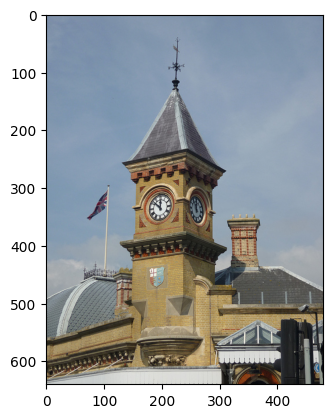

A building with clock and a weathervane on top.
['A young man riding a skateboard on a hand rail'
 'A man is doing skateboard tricks on a metal railing.'
 'A skateboarder doing a trick on a rail.'
 'A boy slides along a rail on his skateboard.'
 'A skateboard rider on top of a handrail by a path in the city']


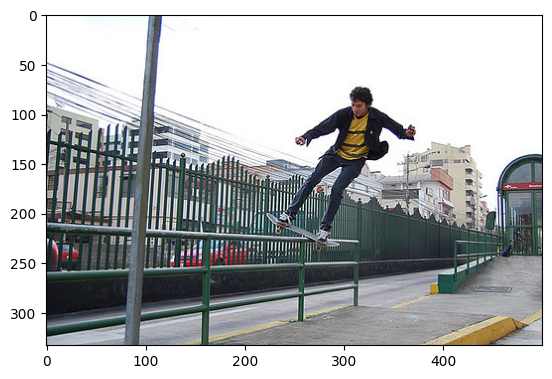

A man dressed in warm clothes skateboarding in a public area.
['A person is leaning low on their motorcycle on the tracks.'
 'A person leaning down on a motorcycle as they ride on a track.'
 'A man riding no a motorcycle down a race tracks.'
 'A man is nearly sideways while racing a motorcycle around a track.'
 "A man with a helmet is riding a motorcycle on it's side."]


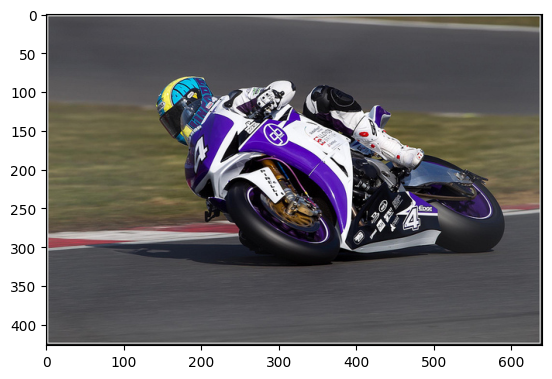

A motorcyclists racing a motorcycle on a race track.
['A person sitting outdoors with a Frisbee in front of their face.'
 'This is a picture of a Frisbee  stuck to a guys face.'
 'A boy scout wearing a Frisbee on his face'
 'A man sitting down with a Frisbee on his face.'
 'Person in a khaki shirt with a white frisbee on their face in a park. ']


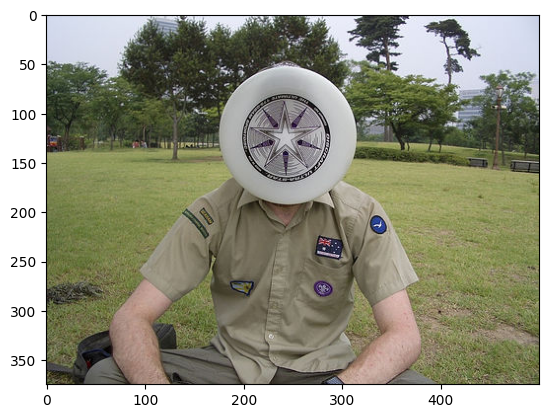

A dog catching a purple Frisbee in it's mouth on a green grass covered field.
['A person with a backpack riding a snowboard down a mountain side.'
 'There is one snowboarding going down the hill. '
 'the person is coming down the hill on a snowboard'
 'A man skiing down a snow covered mountain.'
 'A man riding skis down a snow covered slope.']


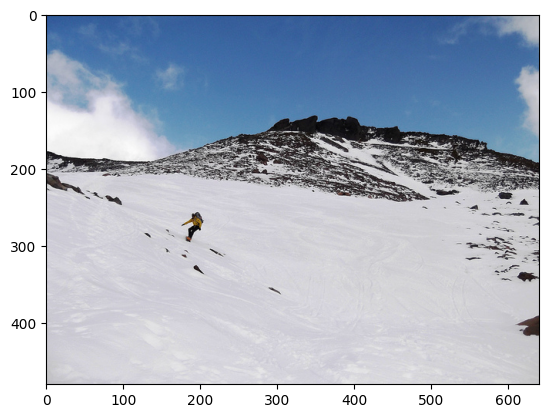

a woman is a green jacket is in the snow


In [17]:


coco_dset = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json',
                        transform=get_transform())
coco_dset1 = dset.CocoCaptions(root = '/content/val2014',
                        annFile = '/content/annotations/captions_val2014.json')

max_captions_per_image = 5

indexToFiveCaption = extractCaptions(coco_dset, max_captions_per_image)
cap_path = '/content/coco_captions.npy'
img_path = '/content/coco_imgs.npy'

indexNCaptionToCaptionEmbedding, indexToImageEmbedding = loadEmbeddings(cap_path, img_path)


embeddingDimention = 512

results = {}
kNearest=1
predicted = []
actual = []

for testImageIndex in range(40300,40305):
    Distances, Indexes = searchNearestNeighbors(indexToImageEmbedding, embeddingDimention, testImageIndex, kNearest,"HNSW")
    KNeighbourIndexes = Indexes[0];
    KNeighbourDistances = Distances[0];
    q1 = compute_query_vector(KNeighbourDistances, KNeighbourIndexes, indexNCaptionToCaptionEmbedding, kNearest)
    closest_captions = rerank_captions(q1, indexNCaptionToCaptionEmbedding, KNeighbourIndexes,coco_dset1,indexToFiveCaption,testImageIndex)
    actual.append(indexToFiveCaption[testImageIndex])
    predicted.append(closest_captions)

    print(captions_np[testImageIndex])
    plt.imshow(coco_dset1[testImageIndex][0])
    plt.show()

    print(closest_captions)





